In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import _tree
from sklearn import metrics
from scipy import stats
from operator import itemgetter
from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.ensemble import GradientBoostingClassifier 


In [2]:
sns.set()

In [3]:
df = pd.read_csv('imputed.csv')

## Impute + 1 hot encode

In [4]:
initial_df = pd.read_csv('HMEQ_Loss.csv')

In [5]:
#break into groups for initial run
numerical_columns = []
categorical_columns = []
other_cols = []

dt=initial_df.dtypes

TARGET_F = 'TARGET_BAD_FLAG'
TARGET_A = 'TARGET_LOSS_AMT'

for i in dt.index:
    if i in ([TARGET_A,TARGET_F]):
        continue
    elif dt[i] in (["object"]) : 
        categorical_columns.append(i)
    elif dt[i] in (["float64"]) : 
        numerical_columns.append(i)
    elif dt[i] in (["int64"]) : 
        numerical_columns.append(i)
    else:
        other_cols.append(i)


In [6]:
#impute the categorical columns
#drop the originals
imputed_df = initial_df.copy()
for i in categorical_columns :
    if imputed_df[i].isna().sum() == 0: 
        continue
    NAME = "IMP_"+i
    imputed_df[NAME] = imputed_df[i]
    imputed_df[NAME] = imputed_df[NAME].fillna(imputed_df[NAME].mode()[0])
    print("variable",i," has this many missing", imputed_df[i].isna().sum())
    print("variable",NAME," has this many missing", imputed_df[NAME].isna().sum() ,'\n')
    g = imputed_df.groupby(NAME)
    print(g[NAME].count())
    print("\n\n")
    imputed_df = imputed_df.drop(i, axis=1)

variable REASON  has this many missing 252
variable IMP_REASON  has this many missing 0 

IMP_REASON
DebtCon    4180
HomeImp    1780
Name: IMP_REASON, dtype: int64



variable JOB  has this many missing 279
variable IMP_JOB  has this many missing 0 

IMP_JOB
Mgr         767
Office      948
Other      2667
ProfExe    1276
Sales       109
Self        193
Name: IMP_JOB, dtype: int64





In [7]:
#impute the numerical columns
#drop the originals
missing_flag_cols = []

for i in numerical_columns:
    if imputed_df[i].isna().sum() == 0:
        continue
    FLAG = 'M_' + i
    IMP = 'IMP_' + i
    imputed_df[FLAG] = imputed_df[i].isna() + 0
    missing_flag_cols.append(FLAG)
    imputed_df[IMP] = imputed_df[i]
    imputed_df.loc[imputed_df[IMP].isna(),IMP] = imputed_df[i].median()
    imputed_df = imputed_df.drop(i, axis=1)

In [8]:
#break into groups again with the dropped cols
imp_numerical_columns = []
imp_categorical_columns = []
imp_other_cols = []

dt=imputed_df.dtypes

TARGET_F = 'TARGET_BAD_FLAG'
TARGET_A = 'TARGET_LOSS_AMT'

for i in dt.index:
    if i in ([TARGET_A,TARGET_F]):
        continue
    elif dt[i] in (missing_flag_cols):
        imp_other_cols.append(i)
    elif dt[i] in (["object"]) : 
        imp_categorical_columns.append(i)
    elif dt[i] in (["float64"]) : 
        imp_numerical_columns.append(i)
    elif dt[i] in (["int64"]) : 
        imp_numerical_columns.append(i)
    else:
        imp_other_cols.append(i)

In [9]:
#now one hot encode the categorical columns
for i in imp_categorical_columns:
    prefix_name = 'z_' + i
    y = pd.get_dummies(imputed_df[i],prefix=prefix_name,drop_first=True)
    imputed_df = pd.concat([imputed_df,y],axis=1)
    imputed_df = imputed_df.drop(i,axis=1)


## Remove the outliers from the dataset


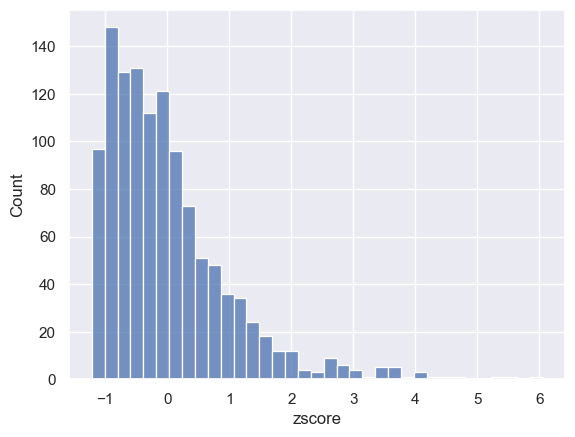

In [10]:
# from the imputed DF, let's keep only things within 3 standard deviations
# we'll use the scipy stats package to get the zscore
outlier_vis = imputed_df.copy()
outlier_vis['zscore'] = stats.zscore(outlier_vis[TARGET_A],nan_policy='omit')

# histogram of zscore
plot1 = sns.histplot(x=outlier_vis['zscore'], data=outlier_vis)
fig = plot1.get_figure()
fig.savefig('zscore_hist.png', bbox_inches='tight')
# get the absolute value of the zscore so we don't have to do > & < to get both upper and lower
# then save that as another df to use later on
# super important here is the or statement in filtering the df
# if you don't use the or part, you end up dropping all the nondefaults
imputed_no_outlier = imputed_df[(np.abs(stats.zscore(imputed_df[TARGET_A],nan_policy='omit')) < 3)\
                                 | ~imputed_df[TARGET_F].isna()].copy()

## Split the Data Into Test & Train

In [11]:
# drop the targets
# keep the predictors
# drop the missing flags as well
# uncomment to use no outlier
# X = imputed_no_outlier.copy()
X = imputed_df.copy()
X = X.drop(TARGET_F,axis=1)
X = X.drop(TARGET_A,axis=1)

for column in imputed_no_outlier.columns.values:
    if "M_" in column:
        X.drop(column,axis=1,inplace=True)

# the target we're predicting
Y = imputed_no_outlier[[TARGET_F,TARGET_A]]

# keep 80% for training
# keep 20% for testing
# use random_state=1 if you need the results to be the same (this sets our seed)
# X_train and Y_train should match up on the index
# X_test and Y_test should match up on the index
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, \
                                                    train_size=0.8, \
                                                    test_size=.2) #random_state=1

print("Training = ", X_train.shape)
print("Testing = ", X_test.shape)

Training =  (4768, 16)
Testing =  (1192, 16)


## Tree Models

### Tree for default or no default

In [12]:
# classify if the person defaulted or not
# f = flag
# m01 = model 1
fm01_Tree = tree.DecisionTreeClassifier(max_depth=5, random_state=511)
fm01_Tree = fm01_Tree.fit(X_train, Y_train[TARGET_F])

# predict with the tree on training set
Y_Pred_train = fm01_Tree.predict(X_train)
print("Train Shape : ",Y_Pred_train.shape)

# predict with the tree on testing set
Y_Pred_test = fm01_Tree.predict(X_test)
print("Test Shape : ",Y_Pred_test.shape)

print("Accuracy Train: ",metrics.accuracy_score(Y_train[TARGET_F], Y_Pred_train))
print("Accuracy Test: ",metrics.accuracy_score(Y_test[TARGET_F], Y_Pred_test))

Train Shape :  (4768,)
Test Shape :  (1192,)
Accuracy Train:  0.8961828859060402
Accuracy Test:  0.8758389261744967


#### ROC Curve

In [13]:
# first 5 values for what the model predicted on the training set
Y_Pred_train[0:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [14]:
# probability for the training set and testing set
train_probs = fm01_Tree.predict_proba(X_train)
test_probs = fm01_Tree.predict_proba(X_test)

# get all the probabilities for defaulted 
# (not default, default) in the data set
train_probs_default = train_probs[:,1]
test_probs_default = test_probs[:,1]

# you can see for training [1] prob of 0.89 
# which corresponds with y_pred_train[1] of 1 
# which the model predicted as defaulted
print("First 5 Training\n",train_probs[0:5],"\n")
print("First 5 Test\n",test_probs[0:5],"\n")

First 5 Training
 [[0.93699732 0.06300268]
 [0.96430808 0.03569192]
 [0.96430808 0.03569192]
 [0.96430808 0.03569192]
 [0.96430808 0.03569192]] 

First 5 Test
 [[0.93699732 0.06300268]
 [0.896      0.104     ]
 [0.96430808 0.03569192]
 [0.85172414 0.14827586]
 [0.71428571 0.28571429]] 



In [15]:
# fpr = false positive rate
# tpr = true positive rate
# threshold = cutoff for fpr/tpr 
fpr_train, tpr_train, train_threshold = metrics.roc_curve(Y_train[TARGET_F], train_probs_default)

# calculate the area under the roc curve
# the higher the value the more accurate the model
roc_auc_train = metrics.auc(fpr_train, tpr_train)

In [16]:
# now do it again for the test data set
fpr_test, tpr_test, test_threshold = metrics.roc_curve(Y_test[TARGET_F], test_probs_default)

# calculate the area under the roc curve
# the higher the value the more accurate the model
roc_auc_test = metrics.auc(fpr_test, tpr_test)

# we're also going to store the results of the test set
# so we can compare it to other trees further on in the notebook
fpr_tree = fpr_test
tpr_tree = tpr_test
auc_tree = roc_auc_test

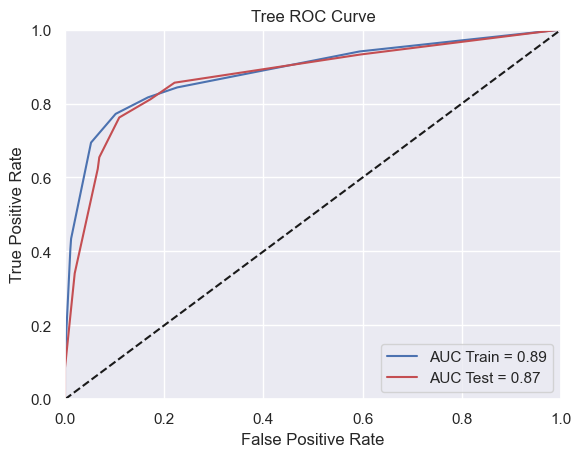

In [17]:
# visualizing the ROC curve
plt.title("Tree ROC Curve")
plt.plot(fpr_train,tpr_train,'b',label = 'AUC Train = %0.2f' % roc_auc_train)
plt.plot(fpr_test,tpr_test,'r',label = 'AUC Test = %0.2f' % roc_auc_test)
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.savefig('Tree_ROC_Curve.png', bbox_inches='tight')

plt.show()

#### Visualizing the Tree Model

In [18]:
# this function will grab the variables used by the tree
def getTreeVars(TREE, varNames) :
    tree_ = TREE.tree_
    varName = [ varNames[i] if i != _tree.TREE_UNDEFINED else "undefined!" for i in tree_.feature ]

    nameSet = set()
    for i in tree_.feature :
        if i != _tree.TREE_UNDEFINED :
            nameSet.add(i)
    nameList = list(nameSet)
    parameter_list = list()
    for i in nameList :
        parameter_list.append(varNames[i])
    return parameter_list

In [19]:
# make a list of all the possible variables from X
feature_cols = list(X.columns.values)

# pass the list along with the tree to the extractor function to get 
# which variables the model used. saved for a future section
vars_tree_flag = getTreeVars(fm01_Tree,feature_cols)

# export the tree as a .txt file to feed into a graphviz tool like GVedit
tree.export_graphviz(fm01_Tree,out_file='treef_f.txt',filled=True,rounded=True,feature_names=feature_cols,\
                     impurity=False,class_names=["No Default","Defaulted"])

vars_tree_flag


['LOAN',
 'IMP_MORTDUE',
 'IMP_VALUE',
 'IMP_DEROG',
 'IMP_DELINQ',
 'IMP_CLAGE',
 'IMP_DEBTINC']

### Tree for default amount

In [20]:
# regression modeling with a tree for the default amount
# we'll carry over the split from the beginning where we split for the default/no default
# we'll also prepend 'a_' to flag the variables for amount
# step one is to get rid of the NaN values for target_loss_amt
F_train = ~Y_train[TARGET_A].isna()

a_X_train = X_train[F_train].copy()
a_Y_train = Y_train[F_train].copy()

F_test = ~Y_test[TARGET_A].isna()

a_X_test = X_test[F_test].copy()
a_Y_test = Y_test[F_test].copy()

print("Training = ", a_X_train.shape)
print("Testing = ", a_X_test.shape)

Training =  (966, 16)
Testing =  (223, 16)


In [21]:
# classify if the person defaulted or not
# a = amount
# m01 = model 1
am01_Tree = tree.DecisionTreeRegressor(max_depth=3, random_state=511)
am01_Tree = am01_Tree.fit(a_X_train, a_Y_train[TARGET_A])

# predict with the tree on training set
a_Y_Pred_train = am01_Tree.predict(a_X_train)
print("Train Shape : ",a_Y_Pred_train.shape)

# predict with the tree on testing set
a_Y_Pred_test = am01_Tree.predict(a_X_test)
print("Test Shape : ",a_Y_Pred_test.shape)


# get Root Mean Square Error
RMSE_train = math.sqrt(metrics.mean_squared_error(a_Y_train[TARGET_A],a_Y_Pred_train))
RMSE_test = math.sqrt(metrics.mean_squared_error(a_Y_test[TARGET_A],a_Y_Pred_test))

print("Tree RMSE Train: ", RMSE_train)
print("Tree RMSE Test: ", RMSE_test)

# save RMSE_test
RMSE_Tree = RMSE_test

# save the variables as well
vars_tree_amt = getTreeVars(am01_Tree,feature_cols)
tree.export_graphviz(am01_Tree,out_file='treef_a.txt',filled=True,rounded=True,feature_names=feature_cols,\
                     impurity=False,precision=0)

Train Shape :  (966,)
Test Shape :  (223,)
Tree RMSE Train:  5414.772476728469
Tree RMSE Test:  5877.74726528094


In [22]:
print("Default Variables: ", vars_tree_flag)
print("Default Amount Variables: ", vars_tree_amt)

Default Variables:  ['LOAN', 'IMP_MORTDUE', 'IMP_VALUE', 'IMP_DEROG', 'IMP_DELINQ', 'IMP_CLAGE', 'IMP_DEBTINC']
Default Amount Variables:  ['LOAN', 'IMP_CLNO', 'IMP_DEBTINC']


## Random Forests

### Random forest for defaulting

In [23]:
# for the random forest, get the features the model finds important
def getEnsembleTreeVars(ENSTREE, varNames) :
    importance = ENSTREE.feature_importances_
    index = np.argsort(importance)
    theList = []
    for i in index :
        imp_val = importance[i]
        if imp_val > np.average(ENSTREE.feature_importances_) :
            v = int(imp_val / np.max(ENSTREE.feature_importances_) * 100)
            theList.append((varNames[i], v))
    theList = sorted(theList,key=itemgetter(1),reverse=True)
    return theList


In [24]:
# create the random forest model
fm01_RF = RandomForestClassifier(n_estimators = 100, max_depth=5,random_state=511)
fm01_RF = fm01_RF.fit(X_train, Y_train[ TARGET_F ])

Y_Pred_train = fm01_RF.predict(X_train)
Y_Pred_test = fm01_RF.predict(X_test)

# show how accurately we can predict defaults
print("Accuracy Train:",metrics.accuracy_score(Y_train[TARGET_F], Y_Pred_train))
print("Accuracy Test:",metrics.accuracy_score(Y_test[TARGET_F], Y_Pred_test))


Accuracy Train: 0.8708053691275168
Accuracy Test: 0.8657718120805369


### ROC Curve

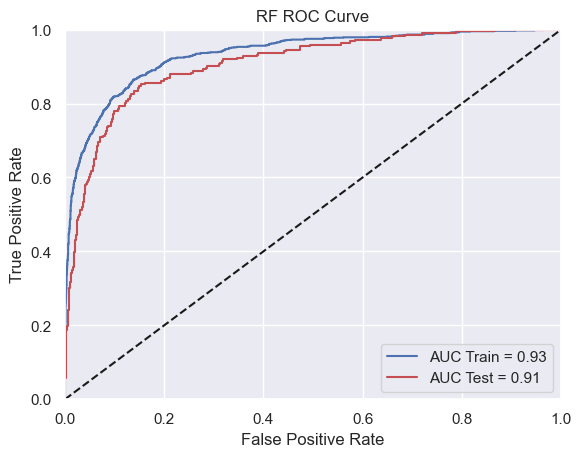

[('IMP_DEBTINC', 100), ('IMP_DELINQ', 55), ('IMP_DEROG', 32), ('IMP_CLAGE', 19)]


In [25]:
probs = fm01_RF.predict_proba(X_train)
p1 = probs[:,1]
fpr_train, tpr_train, threshold = metrics.roc_curve(Y_train[TARGET_F], p1)
roc_auc_train = metrics.auc(fpr_train, tpr_train)

probs = fm01_RF.predict_proba(X_test)
p1 = probs[:,1]
fpr_test, tpr_test, threshold = metrics.roc_curve(Y_test[TARGET_F], p1)
roc_auc_test = metrics.auc(fpr_test, tpr_test)

plt.title("RF ROC Curve")
plt.plot(fpr_train,tpr_train,'b',label = 'AUC Train = %0.2f' % roc_auc_train)
plt.plot(fpr_test,tpr_test,'r',label = 'AUC Test = %0.2f' % roc_auc_test)
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('RF_ROC_Curve.png', bbox_inches='tight')
plt.show()

# save the results for comparison later
fpr_RF = fpr_test
tpr_RF = tpr_test
auc_RF = roc_auc_test

vars_RF_flag = getEnsembleTreeVars(fm01_RF, feature_cols)
print(vars_RF_flag)


### Random Forest for Default Amount

In [26]:
amt_m01_RF = RandomForestRegressor(n_estimators = 100, max_depth=3, random_state=511)
amt_m01_RF = amt_m01_RF.fit(a_X_train, a_Y_train[TARGET_A])

a_Y_Pred_train = amt_m01_RF.predict(a_X_train)
a_Y_Pred_test = amt_m01_RF.predict(a_X_test)

RMSE_Train= math.sqrt(metrics.mean_squared_error(a_Y_train[TARGET_A], a_Y_Pred_train))
RMSE_Test = math.sqrt(metrics.mean_squared_error(a_Y_test[TARGET_A], a_Y_Pred_test))

print("RF RMSE Train:", RMSE_Train)
print("RF RMSE Test:", RMSE_Test)

RMSE_RF = RMSE_Test

vars_RF_amt = getEnsembleTreeVars(amt_m01_RF, feature_cols)
print(vars_RF_amt)

RF RMSE Train: 4688.841281481027
RF RMSE Test: 5162.553185757478
[('LOAN', 100)]


## Gradient Boosting

### Gradient Boosting for defaulting

In [27]:
fm01_GB = GradientBoostingClassifier(n_estimators = 100,max_depth=5, random_state=511)
fm01_GB = fm01_GB.fit(X_train, Y_train[ TARGET_F ])

Y_Pred_train = fm01_GB.predict(X_train)
Y_Pred_test = fm01_GB.predict(X_test)

print("Accuracy Train:",metrics.accuracy_score(Y_train[TARGET_F], Y_Pred_train))
print("Accuracy Test:",metrics.accuracy_score(Y_test[TARGET_F], Y_Pred_test))

Accuracy Train: 0.9664429530201343
Accuracy Test: 0.9135906040268457


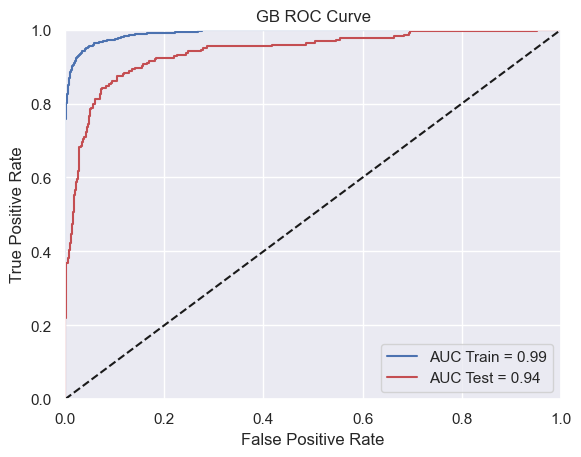

[('IMP_DEBTINC', 100), ('IMP_DELINQ', 34), ('IMP_CLAGE', 22), ('IMP_VALUE', 17)]


In [28]:
probs = fm01_GB.predict_proba(X_train)
p1 = probs[:,1]
fpr_train, tpr_train, threshold = metrics.roc_curve(Y_train[TARGET_F], p1)
roc_auc_train = metrics.auc(fpr_train, tpr_train)

probs = fm01_GB.predict_proba(X_test)
p1 = probs[:,1]
fpr_test, tpr_test, threshold = metrics.roc_curve(Y_test[TARGET_F], p1)
roc_auc_test = metrics.auc(fpr_test, tpr_test)

fpr_GB = fpr_test
tpr_GB = tpr_test
auc_GB = roc_auc_test


plt.title("GB ROC Curve")
plt.plot(fpr_train,tpr_train,'b',label = 'AUC Train = %0.2f' % roc_auc_train)
plt.plot(fpr_test,tpr_test,'r',label = 'AUC Test = %0.2f' % roc_auc_test)
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('GB_ROC_Curve.png', bbox_inches='tight')
plt.show()


vars_GB_flag = getEnsembleTreeVars(fm01_GB, feature_cols)
print(vars_GB_flag)


### Gradient Boosting for Default Amount

In [29]:
amt_m01_GB = GradientBoostingRegressor(n_estimators = 100,max_depth=3,random_state=511)
amt_m01_GB = amt_m01_GB.fit(a_X_train, a_Y_train[TARGET_A])

a_Y_Pred_train = amt_m01_GB.predict(a_X_train)
a_Y_Pred_test = amt_m01_GB.predict(a_X_test)

RMSE_Train = math.sqrt(metrics.mean_squared_error(a_Y_train[TARGET_A], a_Y_Pred_train))
RMSE_Test = math.sqrt(metrics.mean_squared_error(a_Y_test[TARGET_A], a_Y_Pred_test))

print("GB RMSE Train:", RMSE_Train)
print("GB RMSE Test:", RMSE_Test)

RMSE_GB = RMSE_Test

vars_GB_amt = getEnsembleTreeVars(amt_m01_GB, feature_cols)
print(vars_GB_amt)

GB RMSE Train: 1356.6436396959252
GB RMSE Test: 2422.641686742917
[('LOAN', 100), ('IMP_CLNO', 13), ('IMP_DEBTINC', 11)]


## Comparing the three models

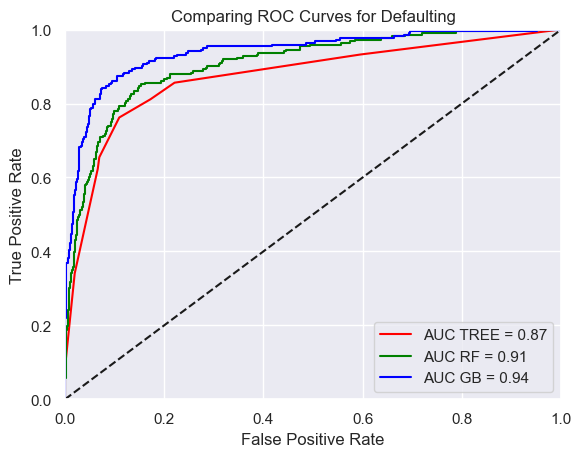

In [30]:
plt.title('Comparing ROC Curves for Defaulting')
plt.plot(fpr_tree, tpr_tree, label = 'AUC TREE = %0.2f' % auc_tree, color="red")
plt.plot(fpr_RF, tpr_RF, label = 'AUC RF = %0.2f' % auc_RF, color="green")
plt.plot(fpr_GB, tpr_GB, label = 'AUC GB = %0.2f' % auc_GB, color="blue")
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('Comparison_ROC_Curve.png', bbox_inches='tight')
plt.show()


In [31]:
print("Root Mean Square Average For Default Amount")
print("TREE", RMSE_Tree)
print("RF", RMSE_RF)
print("GB", RMSE_GB)

Root Mean Square Average For Default Amount
TREE 5877.74726528094
RF 5162.553185757478
GB 2422.641686742917


In [32]:
# variables all the models found important
print('tree flag: ', vars_tree_flag)
print('tree amt: ', vars_tree_amt)

print('rf flag: ', vars_RF_flag)
print('rf amt: ', vars_RF_amt)

print('gb flag: ', vars_GB_flag)
print('gb amt: ', vars_GB_amt)

tree flag:  ['LOAN', 'IMP_MORTDUE', 'IMP_VALUE', 'IMP_DEROG', 'IMP_DELINQ', 'IMP_CLAGE', 'IMP_DEBTINC']
tree amt:  ['LOAN', 'IMP_CLNO', 'IMP_DEBTINC']
rf flag:  [('IMP_DEBTINC', 100), ('IMP_DELINQ', 55), ('IMP_DEROG', 32), ('IMP_CLAGE', 19)]
rf amt:  [('LOAN', 100)]
gb flag:  [('IMP_DEBTINC', 100), ('IMP_DELINQ', 34), ('IMP_CLAGE', 22), ('IMP_VALUE', 17)]
gb amt:  [('LOAN', 100), ('IMP_CLNO', 13), ('IMP_DEBTINC', 11)]


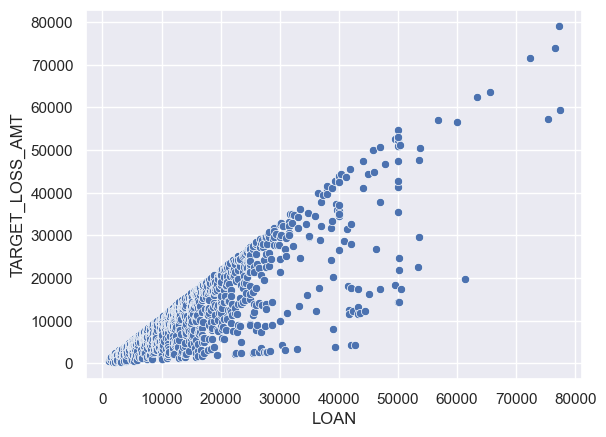

In [33]:
plot2 = sns.scatterplot(x='LOAN',y=TARGET_A,data=imputed_df)
fig = plot2.get_figure()
fig.savefig('Loan_Loss_Scatter.png', bbox_inches='tight')